In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds
import string
import re
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import gensim.downloader as api
from tensorboard.plugins import projector

In [2]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

2024-07-27 22:43:53.787386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 22:43:53.819225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 22:43:53.819317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 22:43:53.824020: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-27 22:43:53.824108: I external/local_xla/xla/stream_executor

In [3]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [4]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [5]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [6]:
training_data=train_ds.map(lambda x,y:x) # input x and y and outputx
vectorize_layer.adapt(training_data) # adapt the vectorize_layer to the training data

In [7]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [8]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [9]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [10]:
vectorize_layer.get_vocabulary()[2443]

'propaganda'

In [11]:
BATCH_SIZE=64

In [12]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

## Modeling

### Simple RNN

In [42]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [44]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,)

Epoch 1/10


2024-07-27 14:47:47.254384: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8032749bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-27 14:47:47.254441: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-27 14:47:47.288613: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-27 14:47:47.357443: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1722071867.470465    2205 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 250s 634ms/step - loss: 0.6946 - accuracy: 0.5008 - val_loss: 0.6945 - val_accuracy: 0.5011
Epoch 2/10
391/391 [==============================] - 214s 548ms/step - loss: 0.6837 - accuracy: 0.5433 - val_loss: 0.6962 - val_accuracy: 0.4943
Epoch 3/10
391/391 [==============================] - 211s 539ms/step - loss: 0.6638 - accuracy: 0.5924 - val_loss: 0.6990 - val_accuracy: 0.4990
Epoch 4/10
391/391 [==============================] - 211s 538ms/step - loss: 0.6225 - accuracy: 0.6654 - val_loss: 0.7079 - val_accuracy: 0.4997
Epoch 5/10
391/391 [==============================] - 210s 537ms/step - loss: 0.5512 - accuracy: 0.7518 - val_loss: 0.7480 - val_accuracy: 0.5001
Epoch 6/10
391/391 [==============================] - 214s 546ms/step - loss: 0.4797 - accuracy: 0.8102 - val_loss: 0.7838 - val_accuracy: 0.5008
Epoch 7/10
391/391 [==============================] - 212s 542ms/step - loss: 0.4346 - accuracy: 0.8383 - val_loss: 0.8079 - val_accura

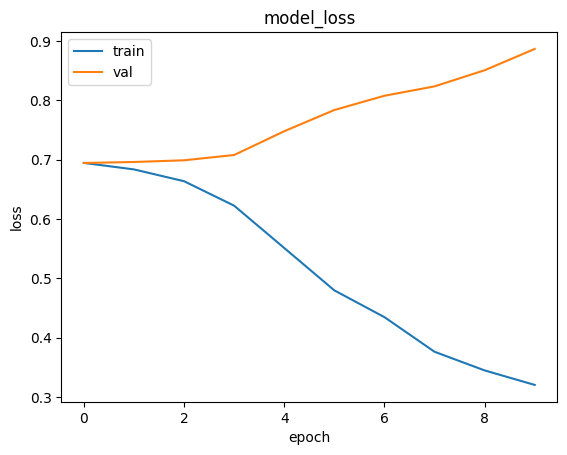

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

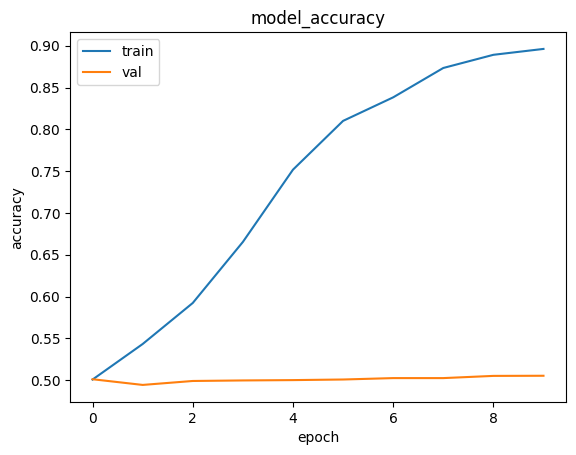

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### LSTM

In [49]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),
    
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [52]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
391/391 [==============================] - 68s 152ms/step - loss: 0.6268 - accuracy: 0.6257 - val_loss: 0.4236 - val_accuracy: 0.8122
Epoch 2/10
391/391 [==============================] - 37s 95ms/step - loss: 0.3421 - accuracy: 0.8631 - val_loss: 0.3293 - val_accuracy: 0.8658
Epoch 3/10
391/391 [==============================] - 38s 96ms/step - loss: 0.2540 - accuracy: 0.9088 - val_loss: 0.3675 - val_accuracy: 0.8622
Epoch 4/10
391/391 [==============================] - 38s 98ms/step - loss: 0.2099 - accuracy: 0.9310 - val_loss: 0.4159 - val_accuracy: 0.8593
Epoch 5/10
391/391 [==============================] - 37s 95ms/step - loss: 0.1873 - accuracy: 0.9383 - val_loss: 0.3781 - val_accuracy: 0.8546
Epoch 6/10
391/391 [==============================] - 38s 96ms/step - loss: 0.1561 - accuracy: 0.9512 - val_loss: 0.4680 - val_accuracy: 0.8270
Epoch 7/10
391/391 [==============================] - 37s 94ms/step - loss: 0.1358 - accuracy: 0.9588 - val_loss: 0.4541 - val_accuracy

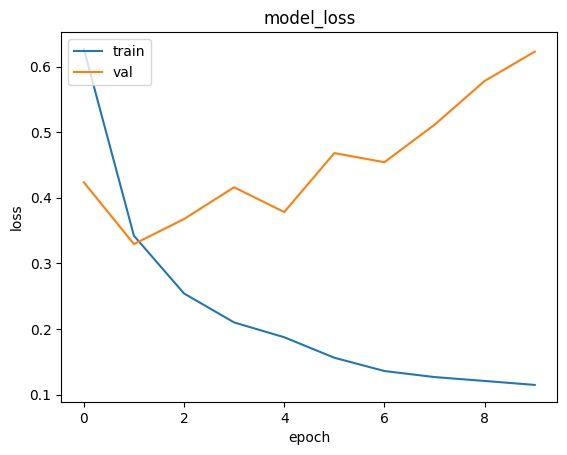

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

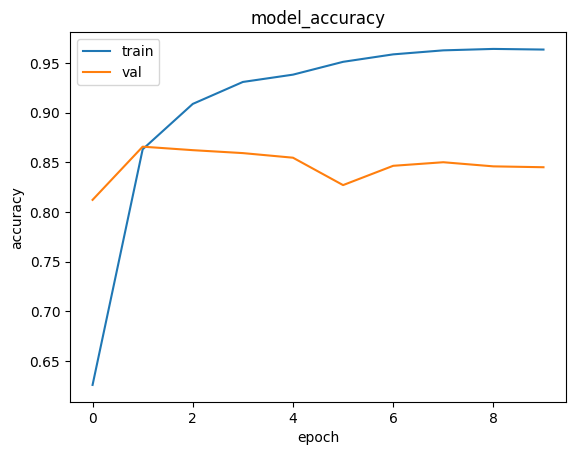

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Conv1D

In [55]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           28832     
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                253984    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 328

In [56]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [57]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10


2024-07-27 15:36:07.521956: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


391/391 [==============================] - 46s 110ms/step - loss: 0.6923 - accuracy: 0.5108 - val_loss: 0.6873 - val_accuracy: 0.5781
Epoch 2/10
391/391 [==============================] - 16s 40ms/step - loss: 0.5252 - accuracy: 0.7469 - val_loss: 0.3538 - val_accuracy: 0.8546
Epoch 3/10
391/391 [==============================] - 16s 40ms/step - loss: 0.2877 - accuracy: 0.8882 - val_loss: 0.3069 - val_accuracy: 0.8722
Epoch 4/10
391/391 [==============================] - 16s 41ms/step - loss: 0.2174 - accuracy: 0.9196 - val_loss: 0.3137 - val_accuracy: 0.8689
Epoch 5/10
391/391 [==============================] - 16s 40ms/step - loss: 0.1717 - accuracy: 0.9427 - val_loss: 0.3367 - val_accuracy: 0.8650
Epoch 6/10
391/391 [==============================] - 16s 41ms/step - loss: 0.1386 - accuracy: 0.9574 - val_loss: 0.3641 - val_accuracy: 0.8606
Epoch 7/10
391/391 [==============================] - 16s 40ms/step - loss: 0.1152 - accuracy: 0.9664 - val_loss: 0.4009 - val_accuracy: 0.8568
Ep

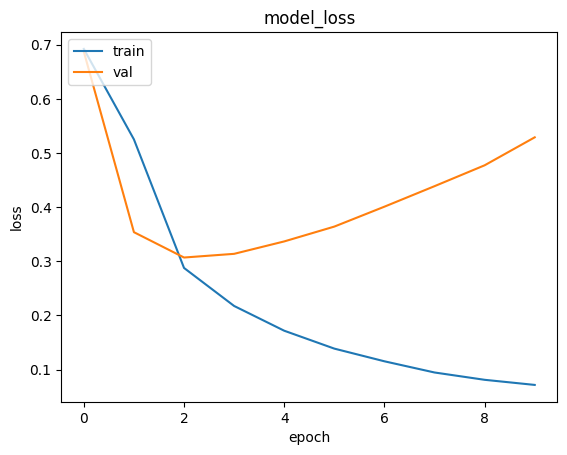

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

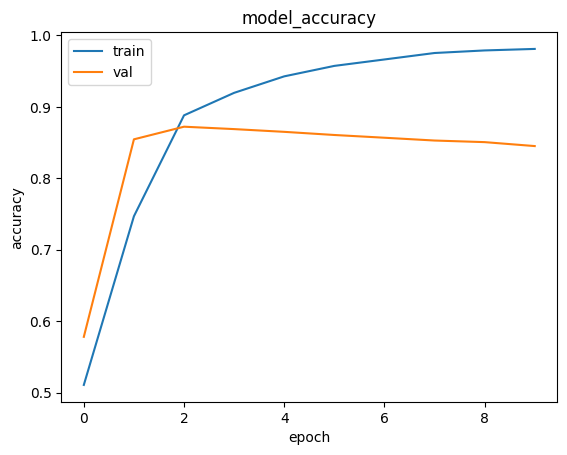

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Word2Vec

word2vec=api.load('word2vec-google-news-300')

In [14]:
word2vec.vectors.shape

(3000000, 300)

In [20]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [21]:
pretrained_embeddings=[]

In [28]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(np.random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)


nosolution
iis==================================== 0
[UNK]
nosolution
and
toupper
a
toupper
of
toupper
to
toupper
doesnt
nosolution
didnt
nosolution
isnt
nosolution
wasnt
nosolution
10
nosolution
80s
nosolution
20
nosolution
70s
nosolution
iis==================================== 1000
15
nosolution
12
nosolution
30
nosolution
humour
toupper
100
nosolution
hasnt
nosolution
90
nosolution
shouldnt
nosolution
favourite
toupper
theatre
toupper
60s
nosolution
40
nosolution
lowbudget
nosolution
tarzan
toupper
50
nosolution
90s
nosolution
1950s
nosolution
iis==================================== 2000
keaton
toupper
welles
toupper
50s
nosolution
1010
nosolution
11
nosolution
1970s
nosolution
overthetop
nosolution
sinatra
toupper
columbo
toupper
1980s
nosolution
25
nosolution
1930s
nosolution
14
nosolution
13
nosolution
bmovie
nosolution
aint
toupper
pacino
toupper
moviethe
nosolution
writerdirector
nosolution
itthe
nosolution
lugosi
toupper
hitchcock
toupper
810
nosolution
iis===================

In [29]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

(10000, 300)


In [30]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           28832     
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense (Dense)               (None, 32)                253984    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 32828

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10


2024-07-27 23:22:20.833183: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-27 23:22:21.162696: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-27 23:22:21.912579: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-27 23:22:23.199138: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f92b49486b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-27 23:22:23.199195: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-27 23:22:23.251120: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722102743.471223  136646 devic

391/391 [==============================] - 53s 120ms/step - loss: 0.6964 - accuracy: 0.5068 - val_loss: 0.6930 - val_accuracy: 0.5132
Epoch 2/10
391/391 [==============================] - 14s 35ms/step - loss: 0.6914 - accuracy: 0.5221 - val_loss: 0.6923 - val_accuracy: 0.5187
Epoch 3/10
391/391 [==============================] - 14s 35ms/step - loss: 0.6869 - accuracy: 0.5377 - val_loss: 0.6878 - val_accuracy: 0.5440
Epoch 4/10
391/391 [==============================] - 14s 36ms/step - loss: 0.5783 - accuracy: 0.6828 - val_loss: 0.4185 - val_accuracy: 0.8200
Epoch 5/10
391/391 [==============================] - 14s 36ms/step - loss: 0.3621 - accuracy: 0.8472 - val_loss: 0.3463 - val_accuracy: 0.8494
Epoch 6/10
391/391 [==============================] - 13s 33ms/step - loss: 0.2885 - accuracy: 0.8866 - val_loss: 0.3249 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 14s 35ms/step - loss: 0.2463 - accuracy: 0.9058 - val_loss: 0.3179 - val_accuracy: 0.8653
Ep

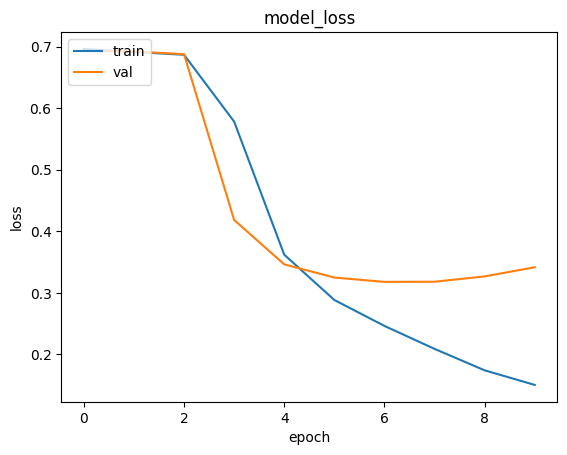

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

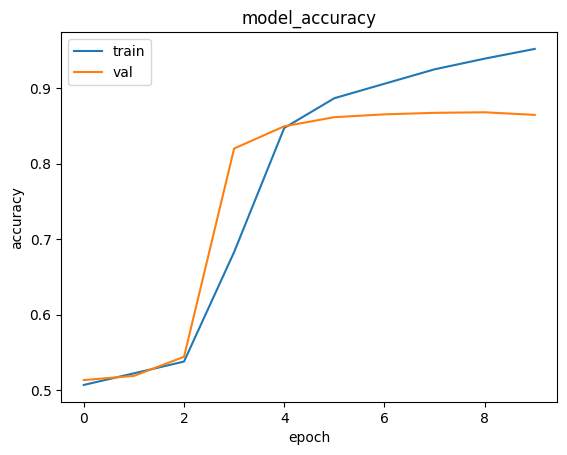

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Inference Ready Testing

In [35]:
inputs = Input(shape=(1,), dtype="string")
vectorized_inputs=vectorize_layer(inputs) 
outputs = model(vectorized_inputs) 
inference_ready_model = tf.keras.Model(inputs, outputs) 
inference_ready_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 250)               0         
 ctorization)                                                    
                                                                 
 sequential (Sequential)     (None, 1)                 3282849   
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 3282849 (12.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
inference_ready_model.predict(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                               "very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "])

1/1 [==============================] - 1s 1s/step


array([[0.5363889 ],
       [0.73798203]], dtype=float32)

## Embedding Visualisation

In [37]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                253984    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 328

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [41]:
log_dir='/mnt/c/Users/Lenovo/logs/imdb/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

In [42]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

In [43]:
history=model.fit(
    train_dataset.take(34),
    validation_data=val_dataset,
    epochs=1,
    callbacks=[tensorboard_callback])

34/34 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5129

2024-07-27 23:31:05.709505: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 720000000 exceeds 10% of free system memory.


34/34 [==============================] - 11s 286ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy: 0.5001


In [47]:
with open(os.path.join(log_dir,'metadata.tsv'),"w",encoding="utf-8") as f:
  for i in range(VOCAB_SIZE):
    f.write("{} {}\n".format(i,vectorize_layer.get_vocabulary()[i]))

In [48]:
embedding_weights=tf.Variable(model.layers[0].get_weights()[0])
print(embedding_weights.shape)

(10000, 300)


In [49]:
checkpoint=tf.train.Checkpoint(embedding=embedding_weights)
checkpoint.save(os.path.join(log_dir,"embedding.ckpt"))

config=projector.ProjectorConfig()
embedding=config.embeddings.add()

In [50]:
embedding.metadata_path='metadata.tsv'
projector.visualize_embeddings(log_dir,config)

In [52]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
%tensorboard --logdir logs/imdb/fit/